In [1]:
!nvidia-smi

Fri Sep 24 03:10:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/My Drive/RR-project/NL2GraphQuery-workplace/code/NLtoGQ')

In [4]:
!pip install transformers

In [5]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchtext.legacy.data import Field, BucketIterator
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer,RobertaModel
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import random
import math
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from multiHop_QA.configures import Config_path, Config_output_path, Hyparams_transformers
from multiHop_QA.model import Encoder, Decoder, Seq2Seq

In [7]:
config = Config_path()
config_output = Config_output_path()

# USE_CUDA = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class RelVocabs():
    def __init__(self, train_combination, test_combination):
        self.train = train_combination
        self.test = test_combination

    def __load_relation(self):
        relation_train = pd.read_csv(self.train,encoding='windows-1252')
        relation_test = pd.read_csv(self.test,encoding='windows-1252')
        rel2id = {}
        id2rel = {}
        special_char = np.array(['[PAD]', '[CLS]', '[UNK]', '[SEP]'])
        relations = pd.concat([pd.Series(special_char), relation_train['relationship'],
                               relation_test['relationship']],
                              axis=0)
        relations = relations.unique()
        relations[100],relations[1] = relations[1],relations[100]
        relations[101],relations[2] = relations[2],relations[101]
        relations[102],relations[3] = relations[3],relations[102]
        idx = 0
        for relation in relations:
            # add one more loop (split)
            rel2id[relation] = idx
            id2rel[idx] = relation
            idx += 1
        return rel2id, id2rel

    def get_rl_vocabs(self):
        return self.__load_relation()


class QuesVocabs():
    def __init__(self, train_combination, test_combination):
        self.train = train_combination
        self.test = test_combination

    def __load_mask_q(self):
        mask_q_train = pd.read_csv(self.train,encoding='windows-1252')
        mask_q_test = pd.read_csv(self.test,encoding='windows-1252')
        q2id = {}
        id2q = {}
        special_char = np.array(['[PAD]', '[CLS]', '[UNK]', '[SEP]'])
        mask_qs = pd.concat([pd.Series(special_char), mask_q_train['question_sep'],
                             mask_q_test['question_sep']],
                            axis=0)
        mask_qs = mask_qs.str.split(expand=True).stack()
        mask_qs = mask_qs.unique()
        idx = 0
        for mask_q in mask_qs:
            # add one more loop (split)
            q2id[mask_q] = idx
            id2q[idx] = mask_q
            idx += 1
        return q2id, id2q

    def get_ques_vocabs(self):
        return self.__load_mask_q()


class LoadData:
    def __init__(self, train_combination, test_combination, q2id, rel2id):
        self.train = train_combination
        self.test = test_combination
        self.q2i = q2id
        self.rel2id = rel2id

    def __split_data(self):
        train = pd.read_csv(self.train,encoding='windows-1252')
        test = pd.read_csv(self.test,encoding='windows-1252')
        # test = shuffle(test)
        split = test.shape[0] // 2
        train_q = self.read_docs_to_seqs(train['question_sep'].values, is_pretrain=True)
        train_rel = self.read_docs_to_seqs(train['relationship'].values)
        val_q = self.read_docs_to_seqs(test['question_sep'][0:split].values, is_pretrain=True)
        val_rel = self.read_docs_to_seqs(test['relationship'][0:split].values)
        test_q = self.read_docs_to_seqs(test['question_sep'][split:-1].values, is_pretrain=True)
        test_rel = self.read_docs_to_seqs(test['relationship'][split:-1].values)
        return train_q, train_rel, val_q, val_rel, test_q, test_rel

    def read_docs_to_seqs(self, docs, is_pretrain=False):
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        tokenizer.add_tokens(["<e>"], special_tokens=True)
        seqs = []
        for doc in docs:
            if doc == "":
                continue
            if is_pretrain:
                sent = "[CLS] " + doc + "[SEP]"
                # Split the sentence into tokens.
                tokenized_text = tokenizer.tokenize(sent)
                # Map the token strings to their vocabulary indeces.
                indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
                # print('+++++', doc)
                # print('seq++++++++++', indexed_tokens)
                seqs.append(indexed_tokens)
            else:
                words = doc.split(" ")
                seq = [self.rel2id["[CLS]"]]
                for word in words:
                    if word in self.rel2id:
                        seq.append(self.rel2id[word])
                # seq = [w2id[word] for word in words if word in w2id]
                seq.append(self.rel2id["[SEP]"])
                # print('+++++',words)
                # print('seq++++++++++', seq)
                seqs.append(seq)
        return seqs

    def get_mask_data(self):
        return self.__split_data()


def iterate_batches(pairs, batch_size, shuffle=True):
    if shuffle:
        random.shuffle(pairs)
    if batch_size is not None:
        n = len(pairs) // batch_size
    else:
        n = 1
        batch_size = len(pairs)

    start_idx = 0
    while start_idx < n:
        pairs_batch = pairs[start_idx:start_idx + batch_size]

        qu_batch = [pair[0] for pair in pairs_batch]
        rl_batch = [pair[1] for pair in pairs_batch]
        qu_lengths = [len(seq) for seq in qu_batch]
        rl_lengths = [len(seq) for seq in rl_batch]
        max_q_length = max(qu_lengths)
        max_r_length = max(rl_lengths)

        seqs_padded = []
        for seq in qu_batch:
            seqs_padded.append(seq + [0 for pad_num in range(max_q_length - len(seq))]) # 0 is [PAD]
        qu_batch = seqs_padded
        seqs_padded = []
        for seq in rl_batch:
            seqs_padded.append(seq + [rel2id["[PAD]"] for pad_num in range(max_r_length - len(seq))])
        rl_batch = seqs_padded
        qu_batch = Variable(torch.LongTensor(qu_batch))  # .transpose(0, 1)
        # (batch_size x max_len) tensors, transpose into (max_len x batch_size)
        rl_batch = Variable(torch.LongTensor(rl_batch))  # .transpose(0, 1)
        qu_batch = qu_batch.to(device)
        rl_batch = rl_batch.to(device)

        start_idx += batch_size

        yield qu_batch, rl_batch


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)


def train(model, iterator, optimizer, criterion, clip):  #####
    model.train()
    epoch_loss = 0
    # src, q_lengths, trg, r_lengths = iterate_batches(pairs, hper_params.BATCH_SIZE)
    for batch in iterator:
        src, trg = batch
        optimizer.zero_grad()
        output, _ = model(src, trg[:, :-1])
        # output = [batch size, trg len - 1, output dim]
        # trg = [batch size, trg len]
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)
        # output = [batch size * trg len - 1, output dim]
        # trg = [batch size * trg len - 1]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss


def evaluate(model, iterator, criterion):  #####
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            src, trg = batch
            # src, q_lengths, trg, r_lengths = get_batch(pairs, hper_params.BATCH_SIZE)
            output, _ = model(src, trg[:, :-1])
            # output = [batch size, trg len - 1, output dim]
            # trg = [batch size, trg len]
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)
            # output = [batch size * trg len - 1, output dim]
            # trg = [batch size * trg len - 1]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss


def epoch_time(start_time, end_time):  #####
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


train_combination = config.train_combination_path
test_combination = config.test_combination_path

m_q_vocabs = QuesVocabs(train_combination, test_combination)
q2id, id2q = m_q_vocabs.get_ques_vocabs()

rel_vocabs = RelVocabs(train_combination, test_combination)
rel2id, id2rel = rel_vocabs.get_rl_vocabs()

loadData = LoadData(train_combination, test_combination, q2id, rel2id)
train_q, train_r, val_q, val_r, test_q, test_r = loadData.get_mask_data()

train_pairs = [(s_seq, t_seq) for s_seq, t_seq in zip(train_q, train_r)]
val_pairs = [(s_seq, t_seq) for s_seq, t_seq in zip(val_q, val_r)]
test_pairs = [(s_seq, t_seq) for s_seq, t_seq in zip(test_q, test_r)]
# print(train_pairs)

The model has 54,327,041 trainable parameters
Epoch: 01 | Time: 0m 0s
	Train Loss: 7.666 | Train PPL: 2134.052
	 Val. Loss: 4.548 |  Val. PPL:  94.475
Epoch: 02 | Time: 0m 0s
	Train Loss: 4.751 | Train PPL: 115.724
	 Val. Loss: 5.431 |  Val. PPL: 228.332
Epoch: 03 | Time: 0m 0s
	Train Loss: 4.649 | Train PPL: 104.499
	 Val. Loss: 5.046 |  Val. PPL: 155.444
Epoch: 04 | Time: 0m 0s
	Train Loss: 4.464 | Train PPL:  86.815
	 Val. Loss: 4.359 |  Val. PPL:  78.203
Epoch: 05 | Time: 0m 0s
	Train Loss: 4.108 | Train PPL:  60.811
	 Val. Loss: 4.232 |  Val. PPL:  68.842
Epoch: 06 | Time: 0m 0s
	Train Loss: 4.043 | Train PPL:  56.973
	 Val. Loss: 4.253 |  Val. PPL:  70.347
Epoch: 07 | Time: 0m 0s
	Train Loss: 4.061 | Train PPL:  58.011
	 Val. Loss: 4.009 |  Val. PPL:  55.082
Epoch: 08 | Time: 0m 0s
	Train Loss: 3.787 | Train PPL:  44.114
	 Val. Loss: 3.966 |  Val. PPL:  52.779
Epoch: 09 | Time: 0m 0s
	Train Loss: 3.639 | Train PPL:  38.041
	 Val. Loss: 4.020 |  Val. PPL:  55.700
Epoch: 10 | Time:

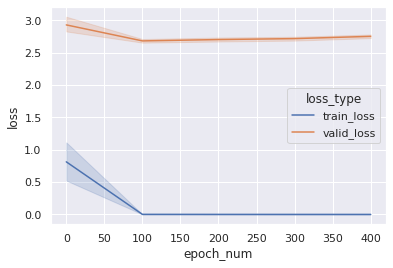

In [9]:
#################################################################################
# Initialize hyper-parameters
hper_params = Hyparams_transformers()
model_name = "0924_BERT_emb_transformers_qspace_best-model-1e4lr.pt"
INPUT_DIM = 36000  ## get  vocab size, 36000 for BERT  51000 for RoBERTa
OUTPUT_DIM = len(rel2id)  ##
best_valid_loss = float('inf')


# Initialize Model
hper_params.BATCH_SIZE = 128
# RoBERTa 1024 hidden layer dimension, BERT 768 dimension
hper_params.HID_DIM = 768
hper_params.ENC_LAYERS = 3
hper_params.DEC_LAYERS = 3
hper_params.ENC_HEADS = 4
hper_params.DEC_HEADS = 4
hper_params.ENC_PF_DIM = 258
hper_params.DEC_PF_DIM = 258
hper_params.ENC_DROPOUT = 0.1
hper_params.DEC_DROPOUT = 0.1
hper_params.LEARNING_RATE = 0.0001
hper_params.N_EPOCHS = 500

enc = Encoder(INPUT_DIM,
              hper_params.HID_DIM,
              hper_params.ENC_LAYERS,
              hper_params.ENC_HEADS,
              hper_params.ENC_PF_DIM,
              hper_params.ENC_DROPOUT,
              device)

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer.add_tokens(["<e>"], special_tokens=True)

# enc.pretrain = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# enc.pretrain = RobertaModel.from_pretrained('roberta-large', output_hidden_states=True)

dec = Decoder(OUTPUT_DIM,
              hper_params.HID_DIM,
              hper_params.DEC_LAYERS,
              hper_params.DEC_HEADS,
              hper_params.DEC_PF_DIM,
              hper_params.DEC_DROPOUT,
              device)

SRC_PAD_IDX = 0
TRG_PAD_IDX = 0

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)  # input/target pad index
# show model's parameters quantity
print(f'The model has {count_parameters(model):,} trainable parameters')
# Initialize model's weights
model.apply(initialize_weights)
# apply learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=hper_params.LEARNING_RATE)
# use loss entropy for backpropagation
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

# training loop
vis_list = []
time_point = 0
for epoch in range(hper_params.N_EPOCHS):
    start_time = time.time()
    train_iterator = iterate_batches(pairs=train_pairs[0:200], batch_size=hper_params.BATCH_SIZE, shuffle=True)
    val_iterator = iterate_batches(pairs=val_pairs, batch_size=hper_params.BATCH_SIZE, shuffle=True)
    train_loss = train(model, train_iterator, optimizer, criterion, hper_params.CLIP)
    valid_loss = evaluate(model, val_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(),
        #            os.path.join(config_output.transformers_path,model_name))
        torch.save(model,
                   os.path.join(config_output.transformers_path, model_name))

    if epoch % 100 == 0:
        time_point = epoch // 20

    vis_list.append([time_point * 20, 'train_loss', train_loss])
    vis_list.append([time_point * 20, 'valid_loss', valid_loss])

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

vis = pd.DataFrame(vis_list, columns=["epoch_num", "loss_type", "loss"])
sns.set_theme(style="darkgrid")
sns.lineplot(x="epoch_num", y="loss",
             hue="loss_type",
             data=vis)
plt.show()

In [10]:
# print test score
# model.load_state_dict(
#     torch.load(os.path.join(config_output.transformers_path,model_name)))
test_iterator = iterate_batches(pairs=test_pairs, batch_size=hper_params.BATCH_SIZE, shuffle=False)
model_ = torch.load(os.path.join(config_output.transformers_path, model_name))
test_loss = evaluate(model_, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.878 | Test PPL:  17.776 |


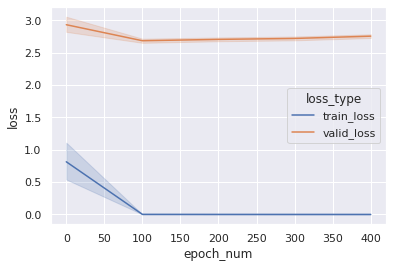

In [11]:
vis = pd.DataFrame(vis_list, columns=["epoch_num", "loss_type", "loss"])
sns.set_theme(style="darkgrid")
sns.lineplot(x="epoch_num", y="loss",
             hue="loss_type",
             data=vis)
plt.show()